In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

/home/muttaqien-m/anaconda3/envs/tsuc2023/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/muttaqien-m/anaconda3/envs/tsuc2023/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Load Image

In [2]:
image_path = "./letterbox.png"
image = cv2.imread(image_path)

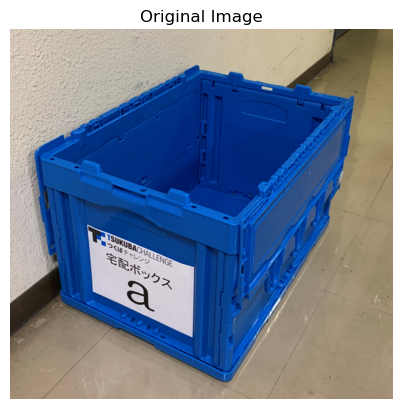

In [3]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()

## Preprocess Image

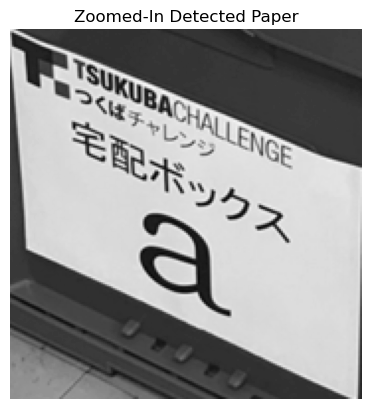

In [4]:
# Read the binary image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply thresholding to convert the image to binary
_, binary_image = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Define a minimum area to filter out small contours
# You may need to adjust this value based on your specific case
min_contour_area = 1e4
max_contour_area = 5e4

# Create a copy of the image to draw on
result_image = image.copy()

# Iterate through the contours and filter out small ones
for contour in contours:
    contour_area = cv2.contourArea(contour)
    
    if contour_area > min_contour_area and contour_area < max_contour_area:
        # Draw a bounding box around the contour
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Extract and display the zoomed-in region
        roi = image[y:y+h, x:x+w]
        plt.imshow(roi, cmap='gray')
        plt.title('Zoomed-In Detected Paper')
        plt.axis('off')
        plt.show()

## Classify Image

In [5]:
# Define the LeNet-3 architecture for A, B, C classification
class LeNet3(nn.Module):
    def __init__(self):
        super(LeNet3, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 3)  # Output for A, B, C

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Initialize the model, loss function, and optimizer
model = LeNet3().to(device)

In [7]:
model.load_state_dict(torch.load('./weights/lenet.pth'))  # Replace with the actual path to your trained model
model.eval()

# Convert the zoomed-in image to a PIL Image
roi_in_pil = Image.fromarray(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))

# Preprocess the zoomed-in image for LeNet
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

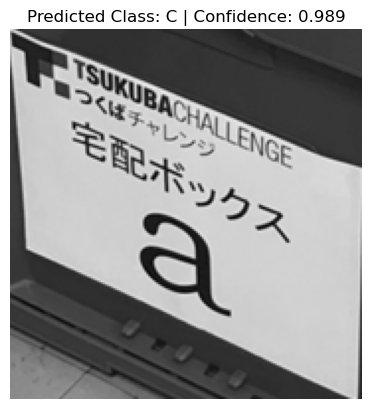

In [8]:
input_image = transform(roi_in_pil)
input_image = input_image.unsqueeze(0).to(device)

# Make a prediction using the LeNet model
with torch.no_grad():
    output = model(input_image)

# Get the predicted class and confidence scores
_, predicted = torch.max(output, 1)
predicted_class = predicted.item()

# Display the confidence scores
confidence = torch.softmax(output, dim=1)[0][predicted.item()].item()
class_names = ['A', 'B', 'C']  # Adjust according to your class names

# Display the zoomed-in image with the predicted class and confidence scores
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.title(f'Predicted Class: {class_names[predicted_class]} | Confidence: {confidence:.3f}')
plt.axis('off')
plt.show()

---